In [1]:
from helpers import * 
from processor import *

ic| cut_vertices: [7, 0]


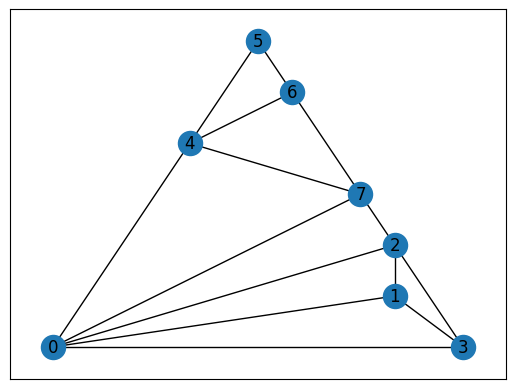

In [2]:
G_st = st_graph()   
p = Processor(G_st)
p.augment()
pos = plot_planar(p.G, p.embed)

ic| tri.target_edge: (0, 3)
ic| 'same y', n1_y: -0.3620689655172414, n2_y: -0.3620689655172414
ic| len(l3_cycles): 8, m: 16, n: 9, m - n + 1: 8


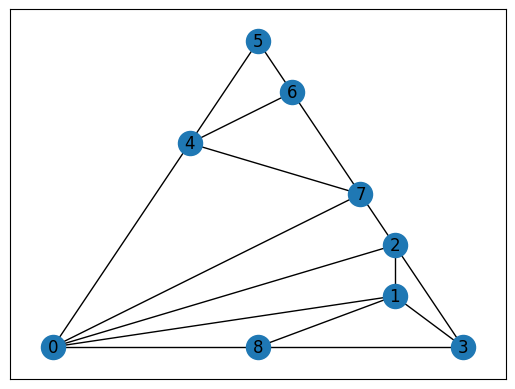

In [3]:
p.fix_separating_triangles()
plot_planar(p.G, p.s.embed)

ic| directions: {'east': (0.2873563218390804, -0.27011494252873564),
                 'north': (0.05747126436781608, 0.23563218390804597),
                 'south': (-0.5862068965517242, -0.3620689655172414),
                 'west': (-0.5862068965517242, -0.3620689655172414)}
ic| directions: {'east': (0.2873563218390804, -0.27011494252873564),
                 'north': (0.05747126436781608, 0.23563218390804597),
                 'south': (-0.5862068965517242, -0.3620689655172414),
                 'west': (-0.5402298850574713, 0.09770114942528735)}
ic| 'Passes planarity check'


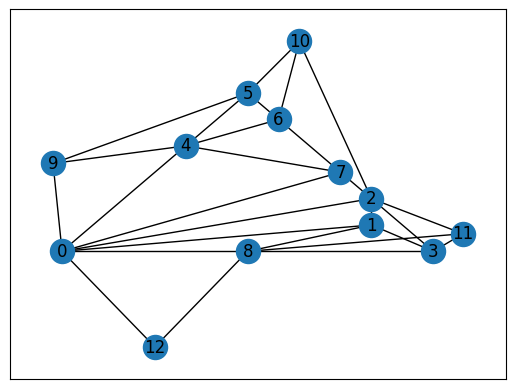

In [4]:
p.fix_cips()
p.add_corner_nodes()
plot_planar(p.b.G, p.b.embed)


In [5]:
corner_node_data = p.b.corner_node_data
def get_node_index(key):
    dict_key = get_key_by_value(corner_node_data, key, object=True)
    return corner_node_data[dict_key].node


In [6]:
corner_node_data

{0: CornerNode({'interior_nodes': [0, 4, 5], 'name': 'west', 'node': 9, 'location': (-1.0402298850574714, 0.09770114942528735), 'mean_location': (-0.5402298850574713, 0.09770114942528735)}),
 1: CornerNode({'interior_nodes': [5, 6, 2], 'name': 'north', 'node': 10, 'location': (0.05747126436781608, 0.735632183908046), 'mean_location': (0.05747126436781608, 0.23563218390804597)}),
 2: CornerNode({'interior_nodes': [2, 3, 8], 'name': 'east', 'node': 11, 'location': (0.7873563218390804, -0.27011494252873564), 'mean_location': (0.2873563218390804, -0.27011494252873564)}),
 3: CornerNode({'interior_nodes': [8, 0], 'name': 'south', 'node': 12, 'location': (-0.5862068965517242, -0.8620689655172413), 'mean_location': (-0.5862068965517242, -0.3620689655172414)})}

In [7]:
G = p.b.G.copy()
embed = p.b.embed

ix = get_node_index # create alias
edges = [(ix("south"), ix("east")),
         (ix("east"), ix("north")),
         (ix("north"), ix("west")),
         (ix("west"), ix("south")),
         (ix("south"), ix("north")),
         ]
G.add_edges_from(edges)

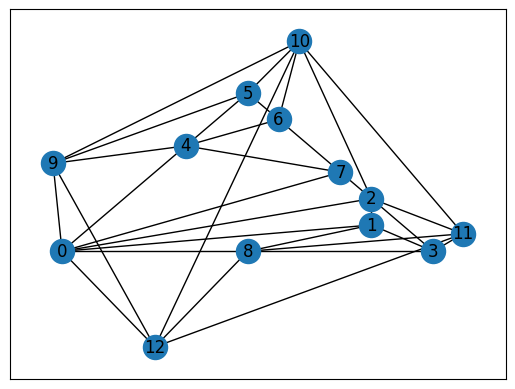

In [8]:
plot_planar(G, embed)

{0: array([-1.        , -0.36206897]), 3: array([ 0.65517241, -0.36206897])}

In [10]:
embed

{0: array([-1.        , -0.36206897]),
 1: array([ 0.37931034, -0.22413793]),
 2: array([ 0.37931034, -0.0862069 ]),
 3: array([ 0.65517241, -0.36206897]),
 4: array([-0.44827586,  0.18965517]),
 5: array([-0.17241379,  0.46551724]),
 6: array([-0.03448276,  0.32758621]),
 7: array([0.24137931, 0.05172414]),
 8: array([-0.17241379, -0.36206897]),
 9: array([-1.04022989,  0.09770115]),
 10: array([0.05747126, 0.73563218]),
 11: array([ 0.78735632, -0.27011494]),
 12: array([-0.5862069 , -0.86206897])}

In [11]:
embed[0]

array([-1.        , -0.36206897])

In [12]:
[embed[i] for i in [0,3,4] if i in embed]

[array([-1.        , -0.36206897]),
 array([ 0.65517241, -0.36206897]),
 array([-0.44827586,  0.18965517])]

## start ordering... 

In [13]:
def create_next_graphs(G, subgraph_nodes):
    G_k_minus = nx.subgraph(G, subgraph_nodes)
    G_diff = nx.subgraph(G, set(G.nodes).difference(set(G_k_minus.nodes)))
    return G_k_minus, G_diff

In [28]:
class ListHistoryTracker:
    def __init__(self, lst):
        self.history = [[]]  # Initialize with an empty list as the initial state
        self.current_state = lst[:]  # Make a copy of the initial list
        self.history.append(self.current_state)  # Append the initial state to history

    def append(self, item):
        self.current_state.append(item)
        self._update_history()

    def _update_history(self):
        self.history.append(self.current_state[:])

    def get_history(self):
        return self.history

In [29]:
# set starting canonical 
G.nodes[get_node_index("south")]["canonical_order"] = 1
G.nodes[get_node_index("west")]["canonical_order"] = 2


# define the subgraph 
subgraph_nodes = []
subgraph_nodes.extend([get_node_index("south"), get_node_index("west")])
G_k_minus, G_diff = create_next_graphs(G, subgraph_nodes)

tracker = ListHistoryTracker(subgraph_nodes)


for order in range(2, len(G.nodes)):

    # find next node -> shared nb of past nodes which is in G_diff 
    v1 = subgraph_nodes[-2]
    v2 = subgraph_nodes[-1]
    candidate_nodes = [n for n in G.neighbors(v1) if n in G.neighbors(v2)]
    candidate_nodes_in_G_diff = list(set(candidate_nodes).intersection(set(G_diff.nodes)))
    # ic((v1, v2), candidate_nodes, candidate_nodes_in_G_diff)

    # # check part 3 of refined canonical order theorem -> candidate node has two nbs in G_diff
    for node in candidate_nodes_in_G_diff:
        true_candidate_nodes = [] # TODO rename 

        neighbours = {n for n in G.neighbors(node)}

        if len(set(G_diff.nodes).intersection(neighbours)) >= 2:
            true_candidate_nodes.append(node)
        elif len(G_diff.nodes) <= 2: 
            true_candidate_nodes.append(node)

        assert len(true_candidate_nodes) == 1, "candidate nodes are invalid!"

    next_node = true_candidate_nodes[0]
    # ic((true_candidate_nodes, next_node))
    ic(subgraph_nodes)
    

    G.nodes[next_node]["canonical_order"] = order

    subgraph_nodes.append(next_node)
    tracker.append(next_node)
   
    G_k_minus, G_diff = create_next_graphs(G, subgraph_nodes)

    # check part 1 or theorem G_k_minus is bi-connected, and its boundary has correct edge..
    a = Augment(G_k_minus)
    a.G_biconnect = G_k_minus
    a.test_biconnect()

    # # correct edge check 
    # if len(G_k_minus.nodes) >=3:
    #     b = Boundaries(G_k_minus, p.b.embed) # wghat about when G_k_minus smaller than embed?
    #     b.find_boundary_points()
    #     b.find_boundary_edges()
    #     try:
    #         b.find_cips()
    #         b.find_boundary_cycle()
    #         b.boundary_cycles
    #         ic(subgraph_nodes[0:2], b.boundary_cycles)
    #     except:
    #         ic(b.boundary_nodes, b.boundary_edges)

ic| subgraph_nodes: [12, 9]
ic| subgraph_nodes: [12, 9, 10]
ic| subgraph_nodes: [12, 9, 10, 5]
ic| subgraph_nodes: [12, 9, 10, 5, 6]
ic| subgraph_nodes: [12, 9, 10, 5, 6, 4]
ic| subgraph_nodes: [12, 9, 10, 5, 6, 4, 7]
ic| subgraph_nodes: [12, 9, 10, 5, 6, 4, 7, 0]
ic| subgraph_nodes: [12, 9, 10, 5, 6, 4, 7, 0, 2]
ic| subgraph_nodes: [12, 9, 10, 5, 6, 4, 7, 0, 2, 1]
ic| subgraph_nodes: [12, 9, 10, 5, 6, 4, 7, 0, 2, 1, 3]
ic| subgraph_nodes: [12, 9, 10, 5, 6, 4, 7, 0, 2, 1, 3, 8]


In [48]:
G.nodes.data()

NodeDataView({0: {'corner_or_interior': 'interior', 'canonical_order': 7}, 1: {'corner_or_interior': 'interior', 'canonical_order': 9}, 2: {'corner_or_interior': 'interior', 'canonical_order': 8}, 3: {'corner_or_interior': 'interior', 'canonical_order': 10}, 4: {'corner_or_interior': 'interior', 'canonical_order': 5}, 5: {'corner_or_interior': 'interior', 'canonical_order': 3}, 6: {'corner_or_interior': 'interior', 'canonical_order': 4}, 7: {'corner_or_interior': 'interior', 'canonical_order': 6}, 8: {'corner_or_interior': 'interior', 'canonical_order': 11}, 9: {'corner_or_interior': 'corner', 'canonical_order': 2}, 10: {'corner_or_interior': 'corner', 'canonical_order': 2}, 11: {'corner_or_interior': 'corner', 'canonical_order': 12}, 12: {'corner_or_interior': 'corner', 'canonical_order': 1}})

In [34]:
history = tracker.get_history()
# history[2:]

embed_seq = []
for state in history[2:]:
    filtered_dict = {key: embed[key] for key in state if key in embed}
    embed_seq.append(filtered_dict)


ic| 'failed to get cycle'
ic| b.boundary_nodes: array([0, 1, 2], dtype=int32)
    b.boundary_edges: []
ic| 'failed to get cycle'
ic| b.boundary_nodes: array([1, 2, 3], dtype=int32)
    b.boundary_edges: []
ic| 'failed to get cycle'
ic| b.boundary_nodes: array([1, 2, 3, 4], dtype=int32)
    b.boundary_edges: []


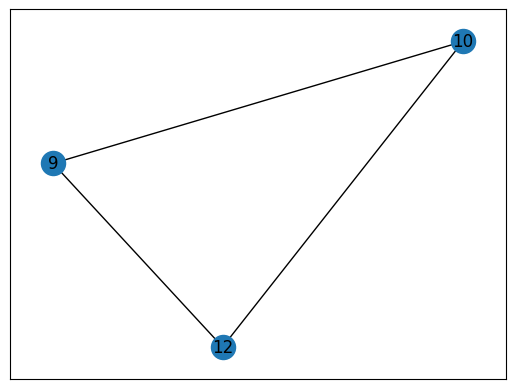

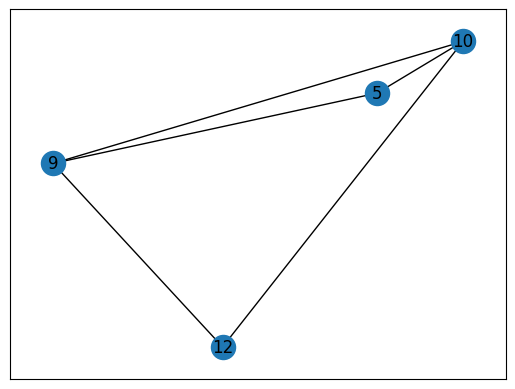

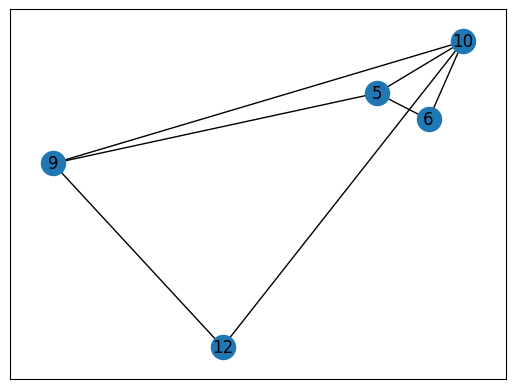

In [41]:
for e in embed_seq[0:3]:
    plt.figure()
    subG = nx.subgraph(G_k_minus, e.keys())
    plot_planar(subG, e)
    if len(e.keys()) >=3:
        b = Boundaries(subG, e) # wghat about when G_k_minus smaller than embed?
        b.find_boundary_points()
        b.find_boundary_edges()
        try:
            b.find_cips()
            b.find_boundary_cycle()
            b.boundary_cycles
            ic(b.boundary_cycles)
        except:
            ic("failed to get cycle")
            ic(b.boundary_nodes, b.boundary_edges)